In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Chicago, conjecture

See one page down for the statement of the conjecture.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import datetime, bz2, csv, collections
import collections
import impute.chicago
import numpy as np
import tilemapbase
import shapely.geometry
import open_cp.geometry
open_cp.geometry.configure_gdal()
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})

## Reload old to new geometry

Rows are `id`, `block`, `datetime`, `location`, `new_point`, `old_point`.

In [3]:
def parse_coord(x):
    return tuple(float(t) for t in x[1:-1].split(", "))

assert parse_coord('(-87.531655723, 41.698387427)') == (-87.531655723, 41.698387427)

with bz2.open("temp.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    assert next(reader) == ["id", "block", "datetime", "location", "new", "old"]
    joined_data = [(row[0], row[1], datetime.datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"),
                   row[3], proj(*parse_coord(row[4])),  proj(*parse_coord(row[5]))) for row in reader]

In [4]:
# Drop jumps > 500m
cutoff = 500**2
i = 0
while i < len(joined_data):
    row = joined_data[i]
    if np.sum((np.asarray(row[4]) - np.asarray(row[5]))**2) > cutoff:
        joined_data.pop(i)
    else:
        i+= 1

## Load reduced graph

In [5]:
import bz2, pickle
import open_cp.network
with open("chicago_merged_graph.pic", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(pickle.load(f))
    reduced_edge_lookup = pickle.loads(bz2.decompress(pickle.load(f)))

## What is the conjecture?

The _conjecture_ is, loosely, that the picture should always look like this example.  To try to articulate that better, we mean that:

- In the "new" data, the points will be clumped about the middle of a "segment" of road
- In the "old" data, the points will be aligned either side of this same "segment".

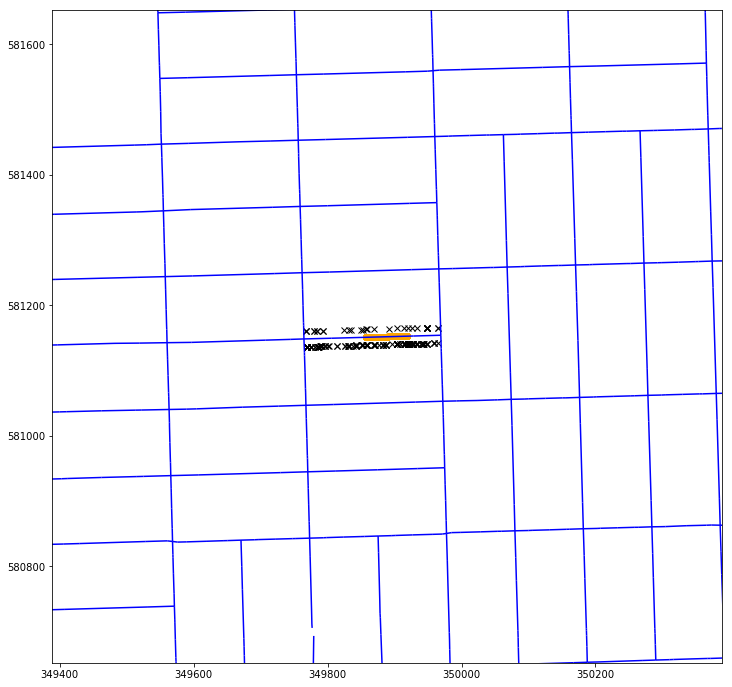

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

block = "042XX W CORTEZ ST"
pts = np.asarray([row[5] for row in joined_data if row[1] == block and row[2] > datetime.datetime(2002,1,1)])
ax.scatter(*pts.T, color="black", marker="x", linewidth=1)
pts = np.asarray([row[4] for row in joined_data if row[1] == block and row[2] > datetime.datetime(2002,1,1)])
ax.scatter(*pts.T, color="orange", marker="o", linewidth=1)

lines = [ [graph.vertices[edge[0]], graph.vertices[edge[1]]] for edge in graph.edges ]
c = matplotlib.collections.LineCollection(lines, color="blue")
ax.add_collection(c)

x, y = np.mean(pts, axis=0)
d = 500
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])
None

## Split the graph into "segments"

In [7]:
segments = list(open_cp.network.segment_graph(graph))

In [8]:
block = "049XX W CORTEZ ST"
pts = np.asarray([row[4] for row in joined_data if row[1] == block and row[2] > datetime.datetime(2002,1,1)])
assert len(pts) > 0
edges = set()
for x, y in pts:
    (v1,v2), _ = graph.project_point_to_graph(x, y)
    e, _ = graph.find_edge(v1, v2)
    edges.add(e)
segments_used = [i for i,seg in enumerate(segments) if any(e in seg for e in edges)]
c = collections.Counter(segments_used)
segment = c.most_common(1)[0][0]
segment

122628

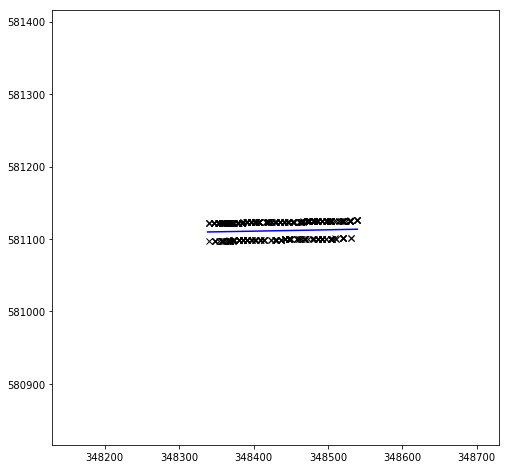

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

pts = np.asarray([row[5] for row in joined_data if row[1] == block])
ax.scatter(*pts.T, color="black", marker="x", linewidth=1)

lines = [ graph.vertices[v] for v in open_cp.network.edge_segment_to_vertices(graph, segments[segment]) ]
c = matplotlib.collections.LineCollection([lines], color="blue")
ax.add_collection(c)

x, y = np.mean(pts, axis=0)
d = 300
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])
None

# Automate this

What we discover:
- There is some pretty complex geometry: street which become separated carriage ways, and over-/under-passes which the TIGER/Lines data does not well model
- Quite a few "blocks" in the data span several "segments" of the graph.

In [24]:
coords_by_block = collections.defaultdict(list)
for row in joined_data:
    if row[2] > datetime.datetime(2002,1,1):
        coords_by_block[row[1]].append(row[4])
old_coords_by_block = collections.defaultdict(list)
for row in joined_data:
    old_coords_by_block[row[1]].append(row[5])
len(coords_by_block)

50539

In [11]:
edge_to_segment = dict()
for index, segment in enumerate(segments):
    for e in segment:
        assert e not in edge_to_segment
        edge_to_segment[e] = index

In [12]:
def used_segments(block):
    """Match new coords to segments"""
    segments_used = []
    for x, y in coords_by_block[block]:
        (v1,v2), _ = graph.project_point_to_graph(x, y)
        e, _ = graph.find_edge(v1, v2)
        segments_used.append(edge_to_segment[e])
    c = collections.Counter(segments_used)
    return [x[0] for x in c.most_common()]

def distance_to_segments(block, segs):
    lines = [[ graph.vertices[v] for v in open_cp.network.edge_segment_to_vertices(graph, segments[segment]) ]
             for segment in segs]
    lines = shapely.geometry.MultiLineString(lines)
    distances = [lines.distance(shapely.geometry.Point(x, y))
        for x, y in old_coords_by_block[block]]
    distances.sort()
    return distances

def plot_block(block, segs, d=300):
    fig, ax = plt.subplots(figsize=(8,8))
    lines = [ [graph.vertices[edge[0]], graph.vertices[edge[1]]] for edge in graph.edges ]
    c = matplotlib.collections.LineCollection(lines, color="black", linewidth=1)
    ax.add_collection(c)
    ax.scatter(*np.asarray(old_coords_by_block[block]).T, color="black", marker="x", linewidth=0.5)
    ax.scatter(*np.asarray(coords_by_block[block]).T)
    lines = [[ graph.vertices[v] for v in open_cp.network.edge_segment_to_vertices(graph, segments[segment]) ]
             for segment in segs]
    c = matplotlib.collections.LineCollection(lines, color="blue", linewidth=3)
    ax.add_collection(c)
    x, y = np.mean(coords_by_block[block], axis=0)
    ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])

In [26]:
block = list(coords_by_block)[2]
block = "030XX N MILWAUKEE AVE"
block, used_segments(block)

('030XX N MILWAUKEE AVE',
 [111495, 124755, 43437, 124724, 61923, 110814, 21367])

In [27]:
distance_to_segments(block, [111495])[-5:]

[151.37626981135256,
 151.37626981135256,
 151.37626981135256,
 151.37626981135256,
 151.37626981135256]

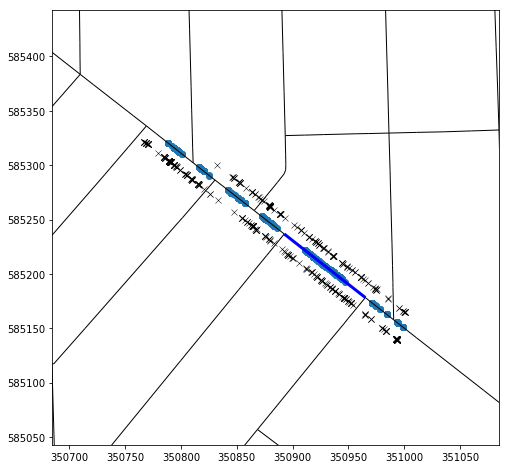

In [28]:
plot_block(block, [111495], 200)

### Automatic test

In [29]:
for index, block in enumerate(coords_by_block):
    used_segs = used_segments(block)
    for i in range(len(used_segs)):
        dists = distance_to_segments(block, used_segs[:i+1])
        if len(dists) < 3 or dists[-2] < 20:
            break
    if i+1 > 4:
        print(index, block, i+1)

65 008XX W 87TH ST 5
267 018XX E 71ST ST 6
294 0000X W CONGRESS PKWY 5
381 0000X W 69TH ST 6
501 038XX W NORTH AVE 5
505 058XX W NORTH AVE 5
611 074XX N ROGERS AVE 5
638 022XX N MILWAUKEE AVE 5
1267 063XX N MILWAUKEE AVE 5
1511 002XX W GARFIELD BLVD 9
1907 066XX S STATE ST 5
1948 058XX S ARCHER AVE 5
2177 039XX W OGDEN AVE 5
2397 032XX S MORGAN ST 5
2776 026XX N GREENVIEW AVE 6
2889 008XX W RANDOLPH ST 5
3055 001XX W 35TH ST 6
3279 028XX N MILWAUKEE AVE 6
3538 050XX S ARCHER AVE 5
4085 008XX N CAMBRIDGE AVE 5
4098 007XX N MILWAUKEE AVE 5
4922 013XX E 87TH ST 5
5192 002XX W 47TH ST 5
5345 054XX W NORTH AVE 5
6798 007XX N OGDEN AVE 5
6884 076XX S EXCHANGE AVE 5
7141 029XX S LYMAN ST 6
7392 056XX N LINCOLN AVE 5
7409 051XX S ARCHER AVE 6
7760 0000X W MARQUETTE RD 8
7834 051XX S DREXEL AVE 5
7874 025XX N CICERO AVE 5
8287 003XX N CICERO AVE 5
8521 012XX W RANDOLPH ST 5
8920 030XX N MILWAUKEE AVE 7
10292 031XX W OGDEN AVE 5
10376 005XX W 87TH ST 5
10978 031XX W LOGAN BLVD 7
11279 006XX W RO

# Look at the data by _segment_ instead of by _block_

In [9]:
# Assuming we're restarted and reloaded data, regenerate the segements...
segments = list(open_cp.network.segment_graph(graph))
edge_to_segment = dict()
for index, segment in enumerate(segments):
    for e in segment:
        assert e not in edge_to_segment
        edge_to_segment[e] = index

In [10]:
by_segment = collections.defaultdict(list)
for row in joined_data:
    block = row[1]
    x, y = row[4]
    (v1,v2), _ = graph.project_point_to_graph(x, y)
    e, _ = graph.find_edge(v1, v2)
    s = edge_to_segment[e]
    by_segment[s].append(block)

In [15]:
by_segment = {k : collections.Counter(v) for k, v in by_segment.items()}

In [25]:
for s, c in by_segment.items():
    if len(c)>10:
        print(s, c)

24051 Counter({'003XX E 131ST PL': 515, '130XX S DR MARTIN LUTHER KING JR DR': 498, '131XX S DANIEL DR': 290, '003XX E 130TH ST': 247, '130XX S DANIEL DR': 180, '002XX E 131ST PL': 137, '131XX S DR MARTIN LUTHER KING JR DR': 73, '003XX E 131 PL': 38, '130XX S DR MARTN LUTHR KING JR DR': 35, '003XX E 130 ST': 35, '002XX E 131 PL': 10, '002XX E 130TH ST': 1, '130XX S KING DR': 1})
45664 Counter({'100XX W OHARE ST': 13876, '0000X W TERMINAL ST': 2135, '0000X W CHECKPOINT 7 ST': 241, '0000X W CHECKPOINT 5 ST': 222, '0000X W CHECKPOINT 7A ST': 136, '0000X W CHECKPOINT 2 ST': 97, '0000X W CHECKPOINT 1 ST': 84, '0000X W CHECKPOINT 6 ST': 62, '0000X W CHECKPOINT 8 ST': 46, '0000X W CHECKPOINT 3 ST': 45, '0000X W C12 ST': 37, '0000X W DOOR E ST': 17, '0000X W DOOR D ST': 16, '0000X W C18 ST': 13, '0000X W DOOR C ST': 12, '0000X W CHECKPOINT 4 ST': 11, '0000X W K5 ST': 10, '0000X W F4 ST': 9, '0000X W K6A ST': 7, '0000X W CHECKPOINT 4A ST': 6, '0000X W C19 ST': 6, '0000X W B9 ST': 6, '0000X W B8

## Conclusions

- Segment `24051` is a loop around a housing project-- hence a lot of different streets get into the same "segment".
- Segment `45664` is a large chunk of the road at the airport
- `45644` is a different airport
- `25362` is a very long segment (near industrial area)
- '1766' is again a long segment (across parkland)

# Save segments as shapefile

In [27]:
import geopandas as gpd

In [29]:
frame = gpd.GeoDataFrame({"segment" : list(range(len(segments)))})
geo = [ shapely.geometry.LineString([ graph.vertices[v]
        for v in open_cp.network.edge_segment_to_vertices(graph, segment) ])
    for segment in segments]
frame.geometry = geo
frame.crs = {"init":"epsg:3528"}
frame.head()

,segment,geometry
0,0,LINESTRING (363793.1375316647 567241.089792814...
1,1,LINESTRING (356237.7647748293 591929.751809108...
2,2,LINESTRING (357566.015621739 586774.9370287169...
3,3,LINESTRING (356237.7647748293 591929.751809108...
4,4,LINESTRING (317311.3098381329 602267.393810999...


In [30]:
frame.to_file("chicago_segments")